# Uvod  
Ovaj projekat demonstrira proces klasifikacije slika koristeći konvolucijsku neuronsku mrežu (CNN). Projekat je implementiran koristeći TensorFlow, visoko-nivojsku biblioteku za duboko učenje. Cilj projekta je da se izgradi model koji može automatski da klasifikuje slike u definisane kategorije.  

# Postavka Projekta  

## Podaci
Podaci se sastoje od slika podeljenih u različite kategorije. Slike su smeštene unutar direktorijuma nazvanog 'test'. Svaka kategorija slika smeštena je u sopstveni poddirektorijum.  

## Parametri
Za obradu slika koristimo sledeće parametre:  

batch_size: 32 - Broj slika koje se procesiraju u jednoj grupi (batch).  
visina_slike i sirina_slike: 256 - Dimenzije na koje se slike skaliraju pre obrade.  

## Podela Podataka
Podaci su podeljeni na tri skupa:  

Trening skup: Koristi se za učenje modela.  
Validacioni skup: Koristi se za podešavanje parametara modela i prevenciju preprilagođavanja.  
Test skup: Koristi se za ocenjivanje finalne performanse modela.  

## Model  
Model koji koristimo je konvolucijska neuronska mreža koja se sastoji od tri konvolucijska sloja, svaki praćen max-pooling slojem, zatim jednog sloja za izravnavanje (Flatten) i dva guste (Dense) sloja. Model je kompilovan sa Adam optimizatorom, funkcijom gubitka SparseCategoricalCrossentropy i metrikom tačnosti (accuracy).  

## Treniranje Modela
Model se trenira na trening skupu uz validaciju na validacionom skupu kroz 10 epoha. Progres treniranja se prati putem tačnosti (accuracy) i gubitka (loss) na oba skupa.  

## Korišćenje Koda
Kod se može koristiti za treniranje modela za klasifikaciju slika. Nakon treniranja, model je spreman za evaluaciju na test skupu kako bi se utvrdila njegova tačnost

In [1]:
import tensorflow as tf
import pathlib
# Definisanje osnovne putanje do direktorijuma sa dataset-om
glavni_dir = pathlib.Path('test')

# Parametri za procesiranje slika
batch_size = 32   # Broj slika koje se procesiraju u jednoj iteraciji
visina_slike = 256
sirina_slike = 256

# Kreiranje skupa podataka za treniranje
train_ds = tf.keras.utils.image_dataset_from_directory(
    glavni_dir,                               # Osnovna putanja do slika
    validation_split=0.3,                   # Postotak podataka koji će se koristiti za validaciju
    subset="training",                      # Specificiranje da se ovo odnosi na skup za treniranje
    seed=123,                               # Seed za slučajno mešanje i podele skupa podataka
    image_size=(visina_slike, sirina_slike),     # Dimenzije slika
    batch_size=batch_size)                  # Velicina batch-a


# Kreiranje skupa podataka za validaciju
val_ds = tf.keras.utils.image_dataset_from_directory(
    glavni_dir,                                # Osnovna putanja
    validation_split=0.3,                    # Postotak podataka za validaciju
    subset="validation",                     # Ovaj skup je za validaciju
    seed=123,                                # Isto kao i za trening set, za konzistentnost
    image_size=(visina_slike, sirina_slike),      # Dimenzije slika
    batch_size=batch_size)                   # Velicina batch-a


# Podela validacionog seta na validacioni i test set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)         # Dve trećine za testiranje
val_ds = val_ds.skip((2*val_batches) // 3)         # Jedna trećina za validaciju

# Čuvanje imena klasa iz trening seta
imena_klasa = train_ds.class_names
print(imena_klasa)

# Dodavanje sloja za normalizaciju slika u dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)             # Slike se skaliraju na vrednosti 0-1
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))   # Primena normalizacije

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(visina_slike, sirina_slike, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dodavanje dropout sloja za regularizaciju
    tf.keras.layers.Dropout(0.5),  # Dodavanje dropout sloja za regularizaciju
    tf.keras.layers.Dense(len(imena_klasa), activation='softmax')  # Koristite softmax za višeklasnu klasifikaciju
])
# Kompilacija modela
model.compile(
    optimizer='adam',                                                       # Optimizator
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),   # Funkcija gubitka
    metrics=['accuracy'])                                                   # Metrika za evaluaciju

# Treniranje modela
epochs=10                                       # Broj epoha za treniranje
history = model.fit(
    train_ds,                                   # Skup podataka za treniranje
    validation_data=val_ds,                     # Skup podataka za validaciju
    epochs=epochs                               # Broj epoha
)


2024-05-08 13:44:19.718115: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 13:44:20.396106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 13:44:20.396306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 13:44:20.468225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 13:44:20.727211: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 13:44:20.734865: I tensorflow/core/platform/cpu_feature_guard.cc:1

Found 1683 files belonging to 19 classes.
Using 1179 files for training.
Found 1683 files belonging to 19 classes.
Using 504 files for validation.


2024-05-08 13:44:26.627261: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


['Enkelad', 'Evropa', 'Fobos', 'Ganimed', 'Jupiter', 'Kalisto', 'Mars', 'Merkur', 'Mesec', 'Mimant', 'Neptun', 'Reja', 'Saturn', 'Uran', 'Venera', 'Zemlja', 'deimos', 'io', 'titan']
Epoch 1/10


/home/pepi/.local/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-05-08 13:44:28.528197: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2024-05-08 13:44:30.262366: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


 1/37 [..............................] - ETA: 2:08 - loss: 2.9547 - accuracy: 0.0312

2024-05-08 13:44:30.737997: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2024-05-08 13:44:32.300802: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


 2/37 [>.............................] - ETA: 1:10 - loss: 4.7430 - accuracy: 0.0156

2024-05-08 13:44:32.758193: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


37/37 [==============================] - 75s 2s/step - loss: 2.2352 - accuracy: 0.3613 - val_loss: 67.5418 - val_accuracy: 0.6739
Epoch 2/10
37/37 [==============================] - 77s 2s/step - loss: 1.1450 - accuracy: 0.6480 - val_loss: 52.9658 - val_accuracy: 0.7663
Epoch 3/10
37/37 [==============================] - 74s 2s/step - loss: 0.8710 - accuracy: 0.7176 - val_loss: 59.1712 - val_accuracy: 0.7772
Epoch 4/10
37/37 [==============================] - 75s 2s/step - loss: 0.7370 - accuracy: 0.7557 - val_loss: 62.5791 - val_accuracy: 0.7772
Epoch 5/10
37/37 [==============================] - 73s 2s/step - loss: 0.6922 - accuracy: 0.7642 - val_loss: 149.8037 - val_accuracy: 0.7011
Epoch 6/10
37/37 [==============================] - 76s 2s/step - loss: 0.7187 - accuracy: 0.7557 - val_loss: 93.4663 - val_accuracy: 0.8098
Epoch 7/10
37/37 [==============================] - 80s 2s/step - loss: 0.5587 - accuracy: 0.7947 - val_loss: 103.4276 - val_accuracy: 0.7609
Epoch 8/10
37/37 [====

Model je treniran na skupu podataka koji sadrži slike koje pripadaju 19 klasa, uključujući različite nebeske objekte kao što su planete, meseci i drugi kosmički entiteti. Trening je izvršen kroz 10 epoha.

Iz rezultata je jasno da se preciznost na trening skupu konstantno poboljšavala kroz epohe, dostigavši veoma visoku preciznost od 99% u poslednjoj epohi. Međutim, uprkos visokoj preciznosti na trening skupu, preciznost na validacionom skupu je niza, što ukazuje na prepilagodjavanje.

Ovo je čest problem u dubokom učenju i zahteva dodatne metode za regulaciju kao što su korišćenje ranog zaustavljanja, dropout, augmentacija ili povećanje skupa podataka.

Koriscenje ranog zaustavljanja je pokusano u ovom primeru i nisu dobijeni bolji rezultati, cak su smanjili uspesost trening skupa, sto se tice povecanja skupa podataka tu je problem ograniceosti podataka i nedovoljno slika planeta i satletila.
Postupkom agumentacije smo uspesno spustili validacione gubiitke i povecalii preciznost. To je pokazano na drugom delu koda.


In [2]:
# Evaluacija modela na test skupu
gubitak, preciznost = model.evaluate(test_ds)
print("Preciznost na test skupu:", preciznost)
print("Gubitak na test skupu:", gubitak)

10/10 [==============================] - 5s 455ms/step - loss: 71.1470 - accuracy: 0.8375
Preciznost na test skupu: 0.8374999761581421
Gubitak na test skupu: 71.14697265625


Iako je preciznost na test skupu slicna kao preciznost na validacionom skupu (znaci, model se definitivno preprilagodio i naucio napamet svoj zadatak), gubitak je katastrofalno visok, sto samo potvrdjuje tu cinjenicu - model nema visoku sposobnost generalizacije.

# Upotreba modela na test skupu

1/1 [==============================] - 0s 486ms/step


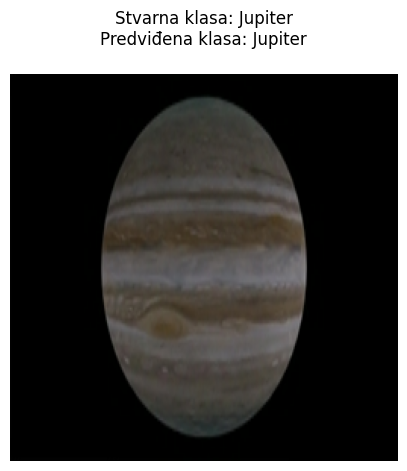

1/1 [==============================] - 0s 33ms/step


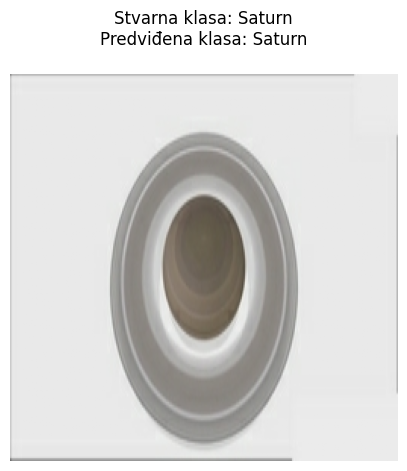

1/1 [==============================] - 0s 30ms/step


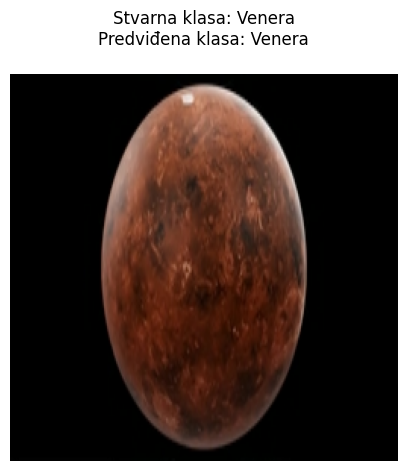

1/1 [==============================] - 0s 32ms/step


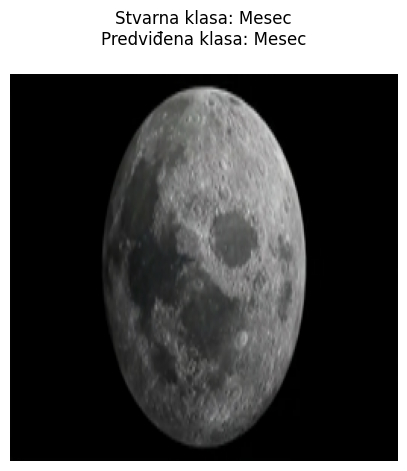

1/1 [==============================] - 0s 30ms/step


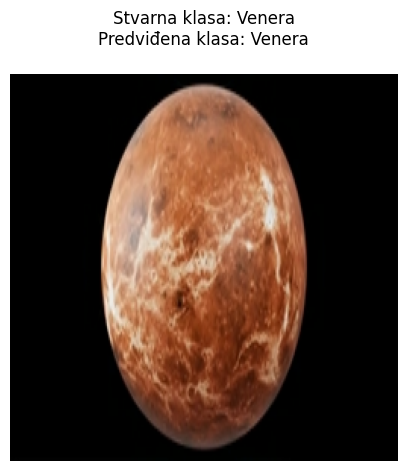

1/1 [==============================] - 0s 31ms/step


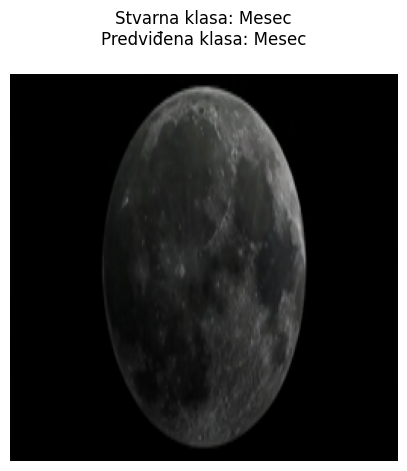

1/1 [==============================] - 0s 35ms/step


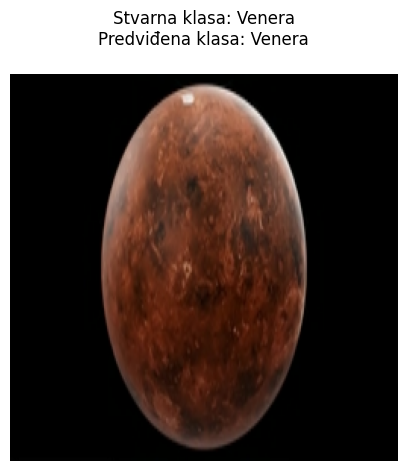

1/1 [==============================] - 0s 31ms/step


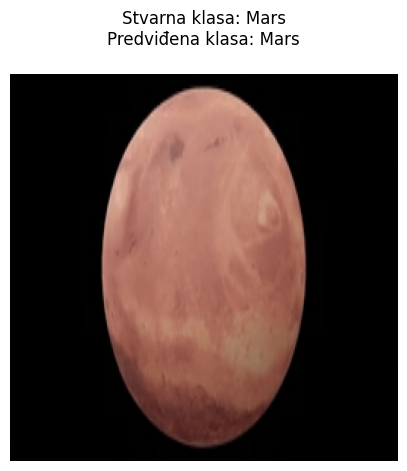

1/1 [==============================] - 0s 32ms/step


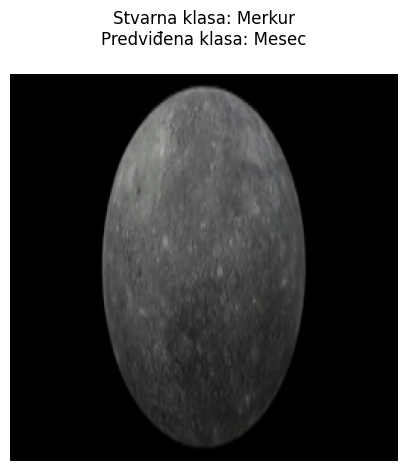

1/1 [==============================] - 0s 32ms/step


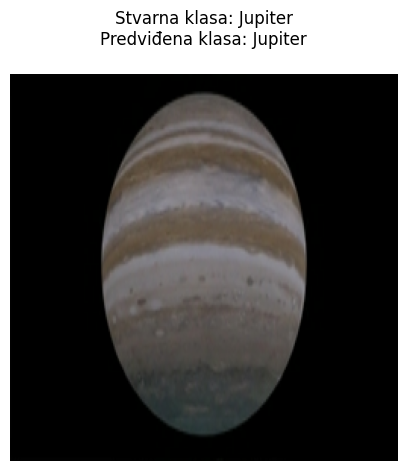

Procenat tačnosti: 90.00%


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Ekstrakcija slika i labela iz test dataset-a
test_slike = []
test_oznake = []
for slike, oznake in test_ds.unbatch().take(30):  # Uzimanje prvih 30 slika i njihovih labela
    test_slike.append(slike.numpy())             # Pretvaranje slika iz tensora u numpy nizove
    test_oznake.append(oznake.numpy())             # Pretvaranje labela iz tensora u numpy nizove

# Nasumični izbor 10 slika iz test skupa za evaluaciju
indeksi = np.random.choice(range(len(test_slike)), 10, replace=False)

# Inicijalizacija promenljivih za evidenciju tačnosti predviđanja
tacne_predikcije = 0
ukupno_predikcija = 0


for i in indeksi:
    img = test_slike[i]
    indeks = test_oznake[i]
    prava_oznaka = imena_klasa[int(indeks)]


    # Normalizacija slike za prikaz, ako je potrebno
    img_to_show = img
    if img_to_show.max() > 1.0:
        img_to_show = img_to_show / 255.0

    img_niz = np.expand_dims(img, axis=0)
    predikcija = model.predict(img_niz)
    indeks_predvidjene_klase = np.argmax(predikcija)
    predvidjena_klasa = imena_klasa[indeks_predvidjene_klase]

    # Provera da li je predviđena klasa tačna
    tacno = prava_oznaka == predvidjena_klasa
    if tacno:
        tacne_predikcije += 1
    ukupno_predikcija += 1

    plt.figure(figsize=(5, 6))
    plt.imshow(img_to_show)
    plt.title(f"Stvarna klasa: {prava_oznaka}\nPredviđena klasa: {predvidjena_klasa}\n")
    plt.axis('off')
    plt.show()



# Izračunavanje i ispisivanje procenta tačnosti
preciznost_predikcije = (tacne_predikcije / ukupno_predikcija) * 100
print(f"Procenat tačnosti: {preciznost_predikcije:.2f}%")


# Testiranje sa ponavljanjima

1/1 [==============================] - 0s 31ms/step


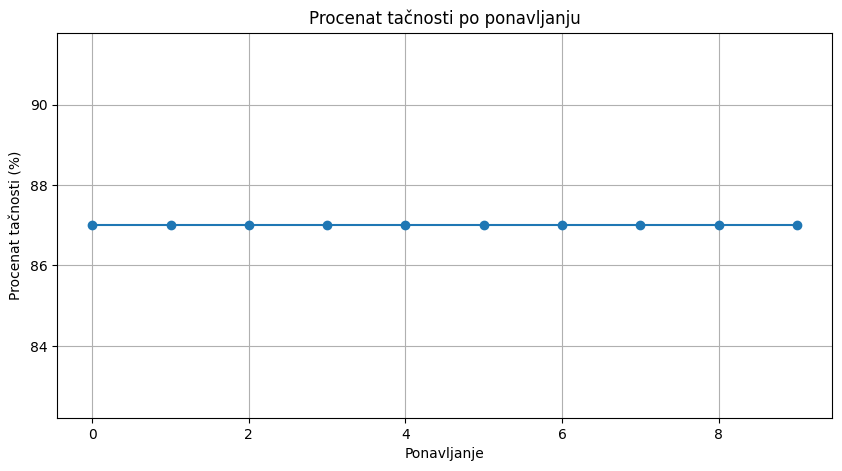

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Pretvaranje test_ds u listu slika i oznaka
test_slike = []
test_oznake = []
for slike, oznake in test_ds.unbatch().take(100):  # Uzmite 400 slika za testiranje
    test_slike.append(slike.numpy())
    test_oznake.append(oznake.numpy())

# Inicijalizacija liste za skladištenje procenata tačnosti
procenat_tacnost = []

# Ponavljanje testiranje 10 puta
for _ in range(10):
    # 100 nasumičnih slika i njihove labele za testiranje
    indeksi = np.random.choice(range(len(test_slike)), 100, replace=False)

    # Inicijalizacija brojača za tačna predviđanja i ukupan broj predviđanja
    tacna_predikcija = 0
    ukupno_predikcija = 0

    for i in indeksi:
        img = test_slike[i]
        indeks = test_oznake[i]
        prava_oznaka = imena_klasa[indeks]

        # Predikcija
        img_niz = np.expand_dims(img, axis=0)
        predikcija = model.predict(img_niz)
        indeks_predvidjene_klase = np.argmax(predikcija)
        predvidjena_klasa = imena_klasa[indeks_predvidjene_klase]

        # Proveravanje tačnosti predviđanja
        tacno = prava_oznaka == predvidjena_klasa
        if tacno:
            tacna_predikcija += 1        # Ažuriranje broja tačnih predviđanja
        ukupno_predikcija += 1              # Ažuriranje ukupnog broja predviđanja

    # Izračunavanje i dodavanje procenta tačnosti u listu
    preciznost = (tacna_predikcija / ukupno_predikcija) * 100
    procenat_tacnost.append(preciznost)

# Crtanje grafika
plt.figure(figsize=(10, 5))
plt.plot(procenat_tacnost, marker='o')
plt.title('Procenat tačnosti po ponavljanju')
plt.xlabel('Ponavljanje')
plt.ylabel('Procenat tačnosti (%)')
plt.grid(True)
plt.show()


# Zakljucak

Model se pokazao izuzetno brz, ali se susreo sa problem preprilagodjavanja  
Testiranje na podacima koje nije prethodno video se pokazalo konzistentno.
Svako testiranje je sadrzalo 100 nasumicnih slika iz test skupa, postupak je ponovljen 10 puta, i ni u jednom trenutku preciznost nije padala ispod 80%, uprkos evaluaciji pomocu funkcije *model.evaluate* koja je pokazala veoma visok gubitak.  

Moze se reci da je preciznost na visokom nivou.


10/10 [==============================] - 4s 370ms/step


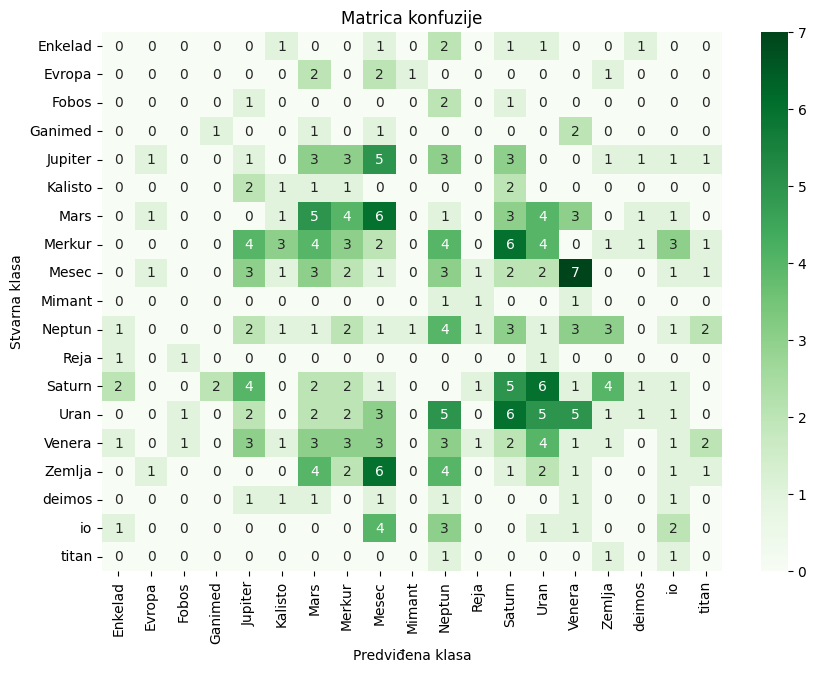

10/10 [==============================] - 4s 410ms/step - loss: 73.7202 - accuracy: 0.8219
Preciznost na test skupu: 0.8218749761581421
Gubitak na test skupu: 73.72021484375


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Predviđanja modela za test skup
predikcije = np.argmax(model.predict(test_ds), axis=-1)

# Stvarne vrednosti za test skup
stvarno = np.concatenate([y for x, y in test_ds], axis=0)

# Izračunavanje matrice konfuzije
matrica_konfuzije = confusion_matrix(stvarno, predikcije)


# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=imena_klasa, columns=imena_klasa)

# Prikaz matrice konfuzije 
plt.figure(figsize=(10, 7))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.show()


# Evaluacija modela na test skupu
gubitak, preciznost = model.evaluate(test_ds)
print("Preciznost na test skupu:", preciznost)
print("Gubitak na test skupu:", gubitak)

In [6]:
model.save('modelT')

INFO:tensorflow:Assets written to: modelT/assets


INFO:tensorflow:Assets written to: modelT/assets
